# Some import

In [35]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, Concatenate

# Load Data

In [2]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {8, 606}, str(val_lung_ids)
assert set(test_lung_ids) == {615, 731}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

In [6]:
len(train_dataset), len(val_dataset), len(test_dataset)

(136, 4, 6)

# Data Visualization

In [25]:
for i in range(len(train_dataset)):
    if train_dataset[i]['Lung_id'] == 6:
        tmp = train_dataset[i+2]
        break

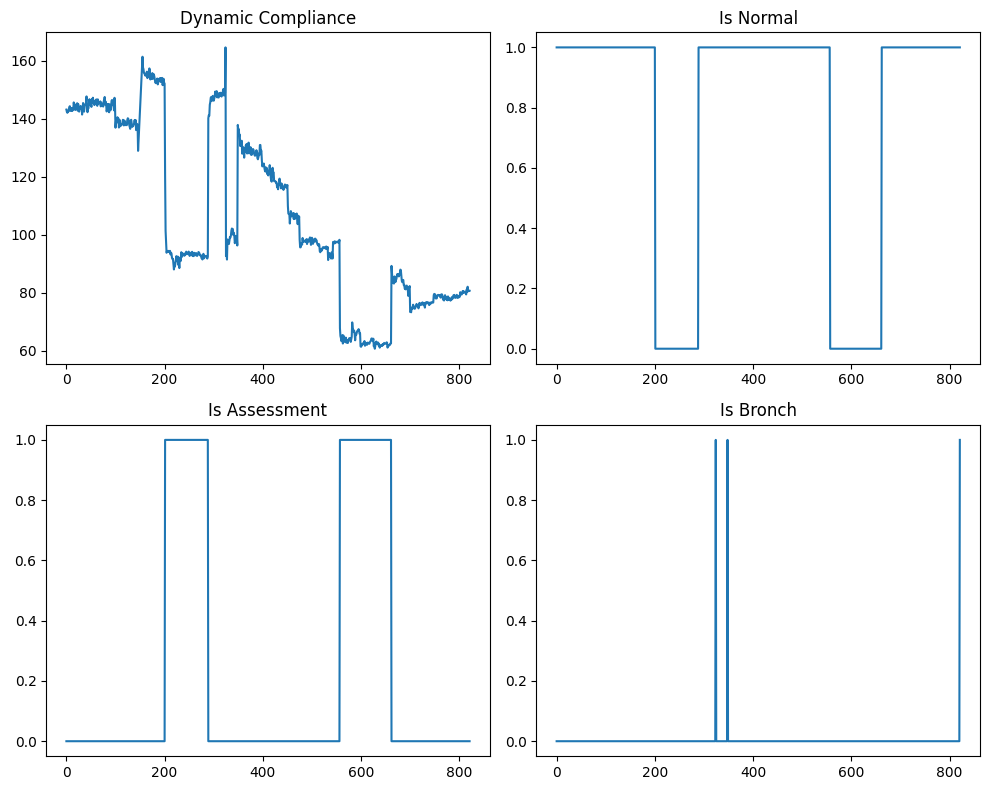

In [26]:
a = tmp['Dy_comp']
c = tmp['Is_normal']
b = tmp['Is_assessment']
d = tmp['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [9]:
def rindex(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [10]:
def center_pad_sequence(sequence, target_length): # centre pad with same value
        current_length = len(sequence)
        total_padding = target_length - current_length
        if total_padding <= 0:
            return sequence

        pad_before = total_padding // 2
        pad_after = total_padding - pad_before

        return np.pad(sequence, (pad_before, pad_after), mode='edge')
len(center_pad_sequence(train_dataset[0]['Is_bronch'][:1+1], 1470))

1470

# Set dataset

In [27]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []

for i in train_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start > last_assessment_start: # if bronch后面没有assessment
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))

print(f"length is {len(X_dc)}")    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

length is 118


In [33]:
X_dc = np.array(X_dc).reshape(-1, 1470)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470)
Y = np.array(Y)

## Don't do this if not PyTorch

In [43]:
X_dc = torch.from_numpy(X_dc).float()
X_is_normal = torch.from_numpy(X_is_normal).float()
X_is_assess = torch.from_numpy(X_is_assess).float()
X_is_bronch = torch.from_numpy(X_is_bronch).float()

TypeError: expected np.ndarray (got Tensor)

# Tensor Flow (Abandoned)

In [36]:
input1 = Input(shape=(1470, 1))
cnn1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

input2 = Input(shape=(1470, 1))
cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(input2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = Concatenate()([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1054, activation='linear')(dense)
model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X_dc, X_is_normal], Y, epochs=1000, verbose=0)

# PyTorch

In [49]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=118, padding = 0):
        super().__init__()

        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv1d(num_in_channels, num_filters, kernel_size = kernel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size = 2),
            torch.nn.Flatten()
            )
        
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size = 2),
            torch.nn.Flatten()
            )
        
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size = 2),
            torch.nn.Flatten()
        )

        self.cnn4 = torch.nn.Sequential(
            torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding = padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size = 2),
            torch.nn.Flatten()
        )
        
        self.layer3 = torch.nn.Sequential( # two Linear for now
            torch.nn.Linear(2936, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1054)
            )

    def forward(self, x_dc, x_normal, x_assessment, x_bronch):
        dy_compliance = self.cnn1(x_dc)
        normal_label = self.cnn2(x_normal)
        assess_label = self.cnn3(x_assessment)
        bronch_label = self.cnn4(x_bronch)
        x = torch.cat((dy_compliance, normal_label, assess_label, bronch_label), dim=1)
        x = self.layer3(x)
        return x

In [50]:
cnn = CNN(kernel=3, num_filters=64, num_in_channels=118)

# LOSS FUNCTION
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [51]:
cnn.forward(X_dc, X_is_normal, X_is_assess, X_is_bronch)

torch.Size([64, 734]) torch.Size([64, 734]) torch.Size([64, 734]) torch.Size([64, 734]) torch.Size([64, 2936])


tensor([[-1.4750e+00, -2.5553e+00,  5.0109e+00,  ..., -1.5641e+00,
         -2.5190e+00, -7.2702e-01],
        [ 1.2649e+00, -1.2114e+00,  3.4464e+00,  ..., -4.1691e-01,
         -2.9929e+00, -7.3583e-02],
        [-1.5319e+00, -2.9652e+00,  4.5275e+00,  ..., -2.7036e+00,
         -2.8152e-01,  3.5516e-01],
        ...,
        [ 7.2565e-02,  5.1821e-03,  7.5240e-02,  ..., -2.3445e-03,
          3.6150e-03,  2.3753e-02],
        [ 8.7304e-01, -6.2252e+00,  1.4239e+01,  ..., -5.2855e+00,
         -9.8612e+00,  2.7352e+00],
        [ 8.3918e-02, -1.4066e-02,  6.8673e-02,  ..., -3.7458e-02,
          4.9704e-02,  4.4707e-02]], grad_fn=<AddmmBackward0>)